In [278]:
#Load modules
from collections.abc import Sequence
from sklearn import preprocessing, svm, datasets
import sklearn.feature_extraction.text as sk_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from scipy.stats import zscore
import pandas as pd
import csv
import io
import requests
import shutil
import os
import time
import numpy as np
from random import seed
from random import randint
from sklearn import metrics
save_path = "./project_weights/project2_weights/"


In [279]:
#Import helper functions

def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

#Encode labels with LabelEncoder
def encode_labels(df, name):
    le = preprocessing.LabelEncoder()
    le.fit(df.drop_duplicates(subset=name)[name])
    df[name]=le.transform(df[name])
    
#Encodes outcome for binary model    
def outcome_encoder(x):
    if x == "normal.":
        return 0
    else:
        return 1
        
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
        
        
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [280]:
#Read data from csv file
df = pd.read_csv('network_intrusion_data.csv')

#Define columns for dataframe
df.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',    
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
] 


df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494016,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


In [281]:
#Drop rows with null values
df.dropna(how='any', inplace=True)

#Drop duplicate rows
df.drop_duplicates(inplace=True)

df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494016,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


In [282]:
#Encode labels
encode_labels(df, 'protocol_type')
encode_labels(df, 'service')
encode_labels(df, 'flag')
encode_labels(df, 'land')
encode_labels(df, 'logged_in')
encode_labels(df, 'is_host_login')
encode_labels(df, 'is_guest_login')

df


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,1,22,9,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
1,0,1,22,9,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
2,0,1,22,9,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,1,22,9,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
4,0,1,22,9,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,1,22,9,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494016,0,1,22,9,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,1,22,9,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494018,0,1,22,9,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


In [283]:
#Encode numeric values
encode_numeric_zscore(df, 'duration')
encode_numeric_zscore(df, 'src_bytes')
encode_numeric_zscore(df, 'dst_bytes')
encode_numeric_zscore(df, 'wrong_fragment')
encode_numeric_zscore(df, 'urgent')
encode_numeric_zscore(df, 'hot')
encode_numeric_zscore(df, 'num_failed_logins')
encode_numeric_zscore(df, 'num_compromised')
encode_numeric_zscore(df, 'root_shell')
encode_numeric_zscore(df, 'su_attempted')
encode_numeric_zscore(df, 'num_root')
encode_numeric_zscore(df, 'num_file_creations')
encode_numeric_zscore(df, 'num_shells')
encode_numeric_zscore(df, 'num_access_files')
encode_numeric_zscore(df, 'num_outbound_cmds')
encode_numeric_zscore(df, 'count')
encode_numeric_zscore(df, 'srv_count')
encode_numeric_zscore(df, 'serror_rate')
encode_numeric_zscore(df, 'srv_serror_rate')
encode_numeric_zscore(df, 'rerror_rate')
encode_numeric_zscore(df, 'srv_rerror_rate')
encode_numeric_zscore(df, 'same_srv_rate')
encode_numeric_zscore(df, 'diff_srv_rate')
encode_numeric_zscore(df, 'dst_host_count')
encode_numeric_zscore(df, 'dst_host_srv_count')
encode_numeric_zscore(df, 'dst_host_same_srv_rate')
encode_numeric_zscore(df, 'dst_host_diff_srv_rate')
encode_numeric_zscore(df, 'dst_host_same_src_port_rate')
encode_numeric_zscore(df, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_serror_rate')
encode_numeric_zscore(df, 'dst_host_srv_serror_rate')
encode_numeric_zscore(df, 'dst_host_rerror_rate')
encode_numeric_zscore(df, 'dst_host_srv_rerror_rate')

df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,-0.10785,1,22,9,-0.004261,-0.039036,0,-0.084394,-0.004737,-0.07021,...,-0.967055,0.979275,-0.417555,-0.177605,-0.315310,-0.644429,-0.641706,-0.360878,-0.353941,normal.
1,-0.10785,1,22,9,-0.004263,-0.025041,0,-0.084394,-0.004737,-0.07021,...,-0.879882,0.979275,-0.417555,-0.260550,-0.315310,-0.644429,-0.641706,-0.360878,-0.353941,normal.
2,-0.10785,1,22,9,-0.004272,-0.025041,0,-0.084394,-0.004737,-0.07021,...,-0.792710,0.979275,-0.417555,-0.260550,-0.315310,-0.644429,-0.641706,-0.360878,-0.353941,normal.
3,-0.10785,1,22,9,-0.004273,-0.013612,0,-0.084394,-0.004737,-0.07021,...,-0.705537,0.979275,-0.417555,-0.302022,-0.315310,-0.644429,-0.641706,-0.360878,-0.353941,normal.
4,-0.10785,1,22,9,-0.004273,-0.013612,0,-0.084394,-0.004737,-0.07021,...,-0.618364,0.979275,-0.417555,-0.302022,-0.315310,-0.644429,-0.641706,-0.360878,-0.353941,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,-0.10785,1,22,9,-0.004222,-0.016095,0,-0.084394,-0.004737,-0.07021,...,1.090221,0.979275,-0.417555,-0.343494,0.512369,-0.644429,-0.619653,-0.360878,-0.353941,normal.
494016,-0.10785,1,22,9,-0.004237,-0.009435,0,-0.084394,-0.004737,-0.07021,...,1.090221,0.979275,-0.417555,0.320064,0.512369,-0.644429,-0.619653,-0.360878,-0.353941,normal.
494017,-0.10785,1,22,9,-0.004281,-0.027294,0,-0.084394,-0.004737,-0.07021,...,1.090221,0.979275,-0.417555,-0.136132,0.512369,-0.511830,-0.619653,-0.360878,-0.353941,normal.
494018,-0.10785,1,22,9,-0.004232,-0.027294,0,-0.084394,-0.004737,-0.07021,...,1.090221,0.979275,-0.417555,-0.219077,0.512369,-0.556030,-0.619653,-0.360878,-0.353941,normal.


In [284]:
#Encode the outcome
#0 for normal. 1 for any attack.
df['outcome'] = df['outcome'].map(outcome_encoder)

In [285]:
#Drop columns that contain null values
df.dropna(axis=1, how='any', inplace=True)

In [286]:
#Split df into x and y arrays for TensorFlow input
x,y = to_xy(df, 'outcome')

In [287]:
#Create train/test split for FCNN
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=42)

In [288]:
#Create 4-dimensional array for CNN image processing
cols = x.shape[1]
rows = x.shape[0]
cnn_x = x.reshape(rows, 1, cols, 1)

In [289]:
#Create train/test split for CNN
cnn_x_train, cnn_x_test, cnn_y_train, cnn_y_test = train_test_split(cnn_x, y, test_size=0.25, random_state=42)

In [290]:
#Neural Network

checkpointer = ModelCheckpoint(os.path.join(save_path,"best_weights.hdf5"), verbose=0, save_best_only=True) # save best model

#Loop through multiple models
for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(40, input_dim=x.shape[1], activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(10, activation='tanh'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    #Define early stopping
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    

model.load_weights(os.path.join(save_path,"best_weights.hdf5")) # load weights from best model

0
Epoch 1/100
3413/3413 - 2s - loss: 0.0328 - val_loss: 0.0129
Epoch 2/100
3413/3413 - 2s - loss: 0.0127 - val_loss: 0.0096
Epoch 3/100
3413/3413 - 4s - loss: 0.0105 - val_loss: 0.0118
Epoch 4/100
3413/3413 - 3s - loss: 0.0095 - val_loss: 0.0104
Epoch 5/100
3413/3413 - 3s - loss: 0.0089 - val_loss: 0.0081
Epoch 6/100
3413/3413 - 4s - loss: 0.0084 - val_loss: 0.0080
Epoch 7/100
3413/3413 - 4s - loss: 0.0076 - val_loss: 0.0139
Epoch 8/100
3413/3413 - 3s - loss: 0.0074 - val_loss: 0.0092
Epoch 9/100
3413/3413 - 2s - loss: 0.0071 - val_loss: 0.0072
Epoch 10/100
3413/3413 - 3s - loss: 0.0067 - val_loss: 0.0080
Epoch 00010: early stopping
1
Epoch 1/100
3413/3413 - 2s - loss: 0.0307 - val_loss: 0.0147
Epoch 2/100
3413/3413 - 2s - loss: 0.0127 - val_loss: 0.0100
Epoch 3/100
3413/3413 - 3s - loss: 0.0109 - val_loss: 0.0092
Epoch 4/100
3413/3413 - 2s - loss: 0.0098 - val_loss: 0.0089
Epoch 5/100
3413/3413 - 3s - loss: 0.0090 - val_loss: 0.0089
Epoch 6/100
3413/3413 - 3s - loss: 0.0084 - val_loss

In [291]:
#Convolutional Neural Network

#Build model
cnn = Sequential()

cnn.add(Conv2D(64, kernel_size=(1,1), strides=(1,1),
                 activation='relu',
                 input_shape=(1, cols, 1)))
cnn.add(MaxPooling2D(pool_size=(1,1)))
cnn.add(Conv2D(128, kernel_size=(1,1), strides=1,
                 activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,1)))

cnn.add(Flatten())
cnn.add(Dense(1024, activation="tanh"))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation="softmax"))

#Define compiler
cnn.compile(loss="categorical_crossentropy", optimizer="adam")

#Create callbacks
cnn_monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
cnn_checkpointer = ModelCheckpoint(os.path.join(save_path,"best_cnn_weights.hdf5"), verbose=0, save_best_only=True) # save best model

#Fit data
cnn.fit(cnn_x_train, cnn_y_train, validation_data=(cnn_x_test,cnn_y_test), batch_size=128, callbacks=[cnn_monitor, cnn_checkpointer], verbose=2, epochs=1000)  
cnn.load_weights(os.path.join(save_path,"best_cnn_weights.hdf5")) # load weights from best model

Epoch 1/1000
854/854 - 45s - loss: 0.0440 - val_loss: 0.0178
Epoch 2/1000
854/854 - 44s - loss: 0.0182 - val_loss: 0.0132
Epoch 3/1000
854/854 - 46s - loss: 0.0158 - val_loss: 0.0155
Epoch 4/1000
854/854 - 44s - loss: 0.0146 - val_loss: 0.0128
Epoch 5/1000
854/854 - 45s - loss: 0.0133 - val_loss: 0.0130
Epoch 6/1000
854/854 - 45s - loss: 0.0137 - val_loss: 0.0109
Epoch 7/1000
854/854 - 44s - loss: 0.0119 - val_loss: 0.0090
Epoch 8/1000
854/854 - 42s - loss: 0.0121 - val_loss: 0.0089
Epoch 9/1000
854/854 - 43s - loss: 0.0117 - val_loss: 0.0114
Epoch 10/1000
854/854 - 42s - loss: 0.0106 - val_loss: 0.0083
Epoch 11/1000
854/854 - 42s - loss: 0.0107 - val_loss: 0.0075
Epoch 12/1000
854/854 - 43s - loss: 0.0095 - val_loss: 0.0084
Epoch 13/1000
854/854 - 47s - loss: 0.0092 - val_loss: 0.0069
Epoch 14/1000
854/854 - 46s - loss: 0.0091 - val_loss: 0.0087
Epoch 15/1000
854/854 - 45s - loss: 0.0089 - val_loss: 0.0096
Epoch 16/1000
854/854 - 44s - loss: 0.0098 - val_loss: 0.0078
Epoch 00016: earl

In [292]:
#FCNN precision, recall, and f1-score calculations

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)


score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

Accuracy: 0.9981042393603868
Averaged F1: 0.9981041162430855
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21938
           1       1.00      1.00      1.00     14459

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



[[21909    29]
 [   40 14419]]
Plotting confusion matrix


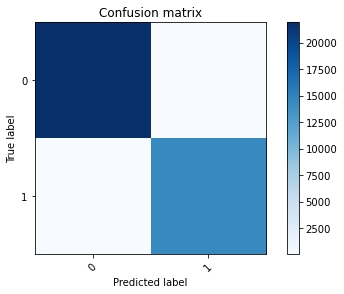

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21938
           1       1.00      1.00      1.00     14459

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [293]:
# Compute confusion matrix for FCNN
cm = confusion_matrix(y_true, pred)
print(cm)

outcome = encode_text_index(df, 'outcome')

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()

print(classification_report(y_true, pred))

In [294]:
#CNN precision, recall, and f1-score calculations

cnn_y_true = np.argmax(cnn_y_test,axis=1)
cnn_pred = cnn.predict(cnn_x_test)
cnn_pred = np.argmax(cnn_pred,axis=1)


cnn_score = metrics.accuracy_score(cnn_y_true, cnn_pred)
print('Accuracy: {}'.format(cnn_score))


cnn_f1 = metrics.f1_score(cnn_y_true, cnn_pred, average='weighted')
print('Averaged F1: {}'.format(cnn_f1))

           
print(metrics.classification_report(cnn_y_true, cnn_pred))

Accuracy: 0.997994340192873
Averaged F1: 0.9979943992618566
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21938
           1       1.00      1.00      1.00     14459

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



[[21899    39]
 [   34 14425]]
Plotting confusion matrix


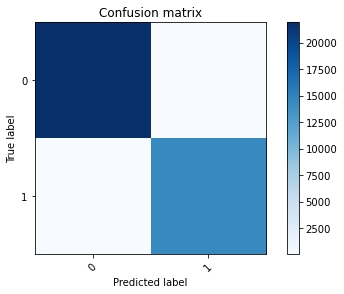

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21938
           1       1.00      1.00      1.00     14459

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [295]:
# Compute confusion matrix for CNN
cnn_cm = confusion_matrix(cnn_y_true, cnn_pred)
print(cnn_cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cnn_cm, outcome)
plt.show()

print(classification_report(cnn_y_true, cnn_pred))